**Autoencoder for defect modeling in mechanical components (Oct. 2020)**

Objectifs de l'exercice: tester différentes dimensions de l'espace latent 50, 1 ou 450. Proposer une façon de comparer les résultats. Proposer un schéma numérique pour interpoler des images. Proposer une visualisation de l'espace latent.  

In [1]:
import sys
print(sys.version)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE, Isomap, MDS

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from tensorflow import stack
from tensorflow.keras.losses import MeanSquaredError
import tensorflow_probability as tfp

from PIL import Image

3.9.0 | packaged by conda-forge | (default, Nov 26 2020, 07:55:15) 
[Clang 11.0.0 ]


In [2]:
class AutoEncoder_defects:
    
    def __init__(self, shape, filters=16, latent_dim=2, lr=0.001, verbose=True, callbacks=None):
        """
        Autoencoder for grey level images.

        Arguments:
            shape: shape of the input image [size_x, size_y, 1]
            filters: number of filters of the first conv layer
            latent_dim = size of the latent space (dimensions of the reduced space)
            lr: learning rate
            verbose = Boolean, if True, will print information about the models
        """
        
        self.input_shape = shape
        self.latent_dim = latent_dim
        self.verbose = verbose

        # Build the Autoencoder Model
        layer_filters = [filters, filters*2]

        # First build the Encoder Model
        inputs = Input(shape=self.input_shape, name='encoder_input')
        x = inputs
        # Stack of Conv2D blocks
        for filters in layer_filters:
            x = Conv2D(filters=filters,
                        kernel_size=3,
                        strides=1,
                        activation='relu',
                        padding='same')(x)
            x = Conv2D(filters=filters,
                        kernel_size=3,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

        # Shape info needed to build Decoder Model
        last_shape = K.int_shape(x)

        # Generate the latent vector
        x = Flatten()(x)
        latent = Dense(self.latent_dim)(x)

        # Instantiate Encoder Model
        self.encoder = Model(inputs, latent)
        if self.verbose:
            self.encoder.summary()

        # Build the Decoder Model
        latent_inputs = Input(shape=(latent_dim,))
        x = Dense(last_shape[1] * last_shape[2] * last_shape[3])(latent_inputs)
        x = Reshape((last_shape[1], last_shape[2], last_shape[3]))(x)

        # Stack of Transposed Conv2D blocks
        for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters,
                                kernel_size=3,
                                strides=2,
                                activation='relu',
                                padding='same')(x)
            x = Conv2D(filters=filters,
                                kernel_size=3,
                                strides=1,
                                activation='relu',
                                padding='same')(x)                            

        # The activation of the output layer is a sigmoid, so that output values
        # are in the same range as input values
        outputs = Conv2D(filters=1,
                        kernel_size=3,
                        strides=1,
                        activation='sigmoid',
                        padding='same')(x)

        # Instantiate Decoder Model
        self.decoder = Model(latent_inputs, outputs)
        if self.verbose:
            self.decoder.summary()

        # Autoencoder = Encoder + Decoder
        # Instantiate Autoencoder Model
        self.autoencoder = Model(inputs, 
                                self.decoder(self.encoder(inputs)),
                                name='autoencoder')
        if self.verbose:
            self.autoencoder.summary()
        
        ## Compile it with an appropriate loss function
        loss_ = 'mse' #loss_jaccard #'mse'
        self.autoencoder.compile(optimizer=Adam(learning_rate=lr), loss=loss_)
        self.autoencoder.summary()
        
    def fit(self, data, epochs, batch_size, validation_split=0.2,callbacks=callbacks):
        return self.autoencoder.fit(x=data, 
                             y=data, 
                             validation_split=validation_split,
                             shuffle=True, 
                             epochs=epochs, 
                             batch_size=batch_size,
                             callbacks=callbacks)

    def predict(self, batch):
        """Autoencode batch of images"""
        return self.autoencoder.predict(batch)

    def save(self, path):
      self.autoencoder.save(path + '/my_autoencoder')
      self.encoder.save(path + '/my_encoder')
      self.decoder.save(path + '/my_decoder')

    def load_model(self, path):
      self.autoencoder = load_model(path + '/my_autoencoder')
      self.encoder = load_model(path + '/my_encoder')
      self.decoder = load_model(path + '/my_decoder')

In [2]:
import os
path = "../IDSC_Données_pour_cette_semaine/"

os.chdir(path)
os.listdir(path)

['my_model_dof',
 'ae_defects_model',
 'Decouverte_Conv2D.ipynb',
 'All_dof_fluctuations.npy',
 '.DS_Store',
 'All_images.npy',
 'mmae',
 'model.png',
 'ae_mechanics_model',
 'TensorOfData_ImageNet.ipynb',
 'IMagenet',
 '.ipynb_checkpoints',
 'TensorFormatDisplacementField.ipynb',
 'help.py',
 'my_model']

In [3]:
image_2D_defects = np.load('All_images.npy')

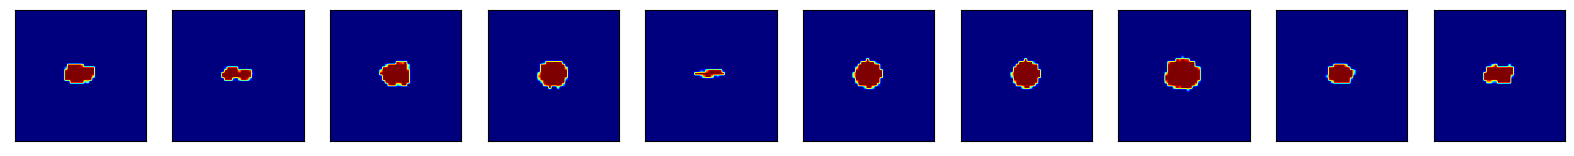

In [4]:
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(image_2D_defects[i],cmap='jet')
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [5]:
N = image_2D_defects.shape[0]
coeff = 0.2

N_split = int(N*(1-coeff))

x = image_2D_defects

x_train = x[:N_split]
x_test = x[N_split:]

In [6]:
x_train = np.expand_dims(x_train, axis = 3)
x_test = np.expand_dims(x_test, axis = 3)
im = np.expand_dims(image_2D_defects, axis = 3)
x_min= x_train.min()
x_max= x_train.max()
x_train = (x_train-x_min)/(x_max-x_min)
x_test = (x_test-x_min)/(x_max-x_min)

In [7]:
x_train.shape

(3200, 48, 48, 1)

In [8]:
LATENT_DIM = 50

shape = x_train.shape[1:4]
ae_defects = AutoEncoder_defects(shape, filters=16, latent_dim=LATENT_DIM, lr=1.e-4, verbose=False)

NameError: name 'AutoEncoder_defects' is not defined

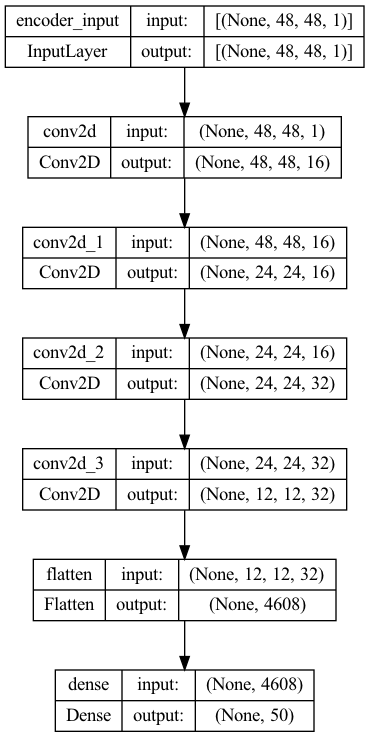

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(ae_defects.encoder, show_shapes=True, show_layer_names=True)

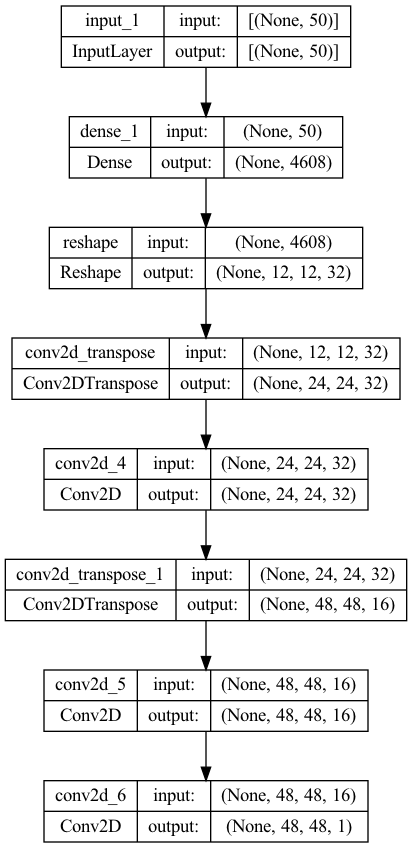

In [12]:
plot_model(ae_defects.decoder, show_shapes=True, show_layer_names=True)

In [13]:
epochs = 150 #150
batch_size = 64 #128
history = ae_defects.fit(x_train, epochs, batch_size, validation_split=0.2)

Epoch 1/150


2022-09-27 16:10:06.594589: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-27 16:10:06.887238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 2s 31ms/step - loss: 0.2450 - val_loss: 0.2358
Epoch 2/150
 1/40 [..............................] - ETA: 0s - loss: 0.2358

2022-09-27 16:10:08.955223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 27ms/step - loss: 0.1286 - val_loss: 0.0227
Epoch 3/150
40/40 [==============================] - 1s 26ms/step - loss: 0.0177 - val_loss: 0.0144
Epoch 4/150
40/40 [==============================] - 1s 27ms/step - loss: 0.0136 - val_loss: 0.0132
Epoch 5/150
40/40 [==============================] - 1s 26ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 6/150
40/40 [==============================] - 1s 26ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 7/150
40/40 [==============================] - 1s 26ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 8/150
40/40 [==============================] - 1s 27ms/step - loss: 0.0099 - val_loss: 0.0091
Epoch 9/150
40/40 [==============================] - 1s 26ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/150
40/40 [==============================] - 1s 26ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 11/150
40/40 [==============================] - 1s 27ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 12/1

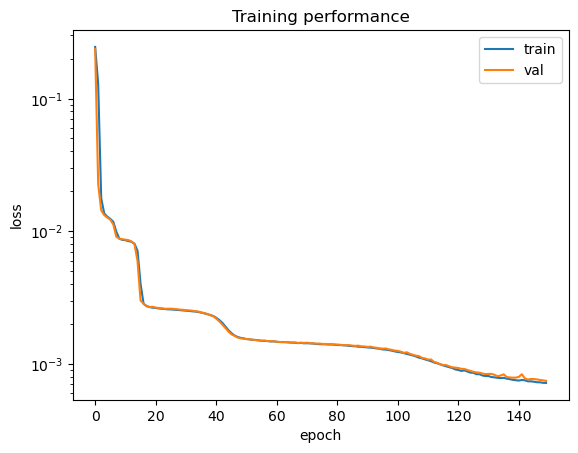

In [14]:
plt.semilogy(history.epoch, history.history['loss'], label='train')
plt.semilogy(history.epoch, history.history['val_loss'], label='val')
plt.title('Training performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [15]:
ae_defects.save('ae_defects_model')

INFO:tensorflow:Assets written to: ae_defects_model/my_autoencoder/assets


INFO:tensorflow:Assets written to: ae_defects_model/my_autoencoder/assets


INFO:tensorflow:Assets written to: ae_defects_model/my_encoder/assets


INFO:tensorflow:Assets written to: ae_defects_model/my_encoder/assets


INFO:tensorflow:Assets written to: ae_defects_model/my_decoder/assets


INFO:tensorflow:Assets written to: ae_defects_model/my_decoder/assets


Latent variables for defects

In [18]:
Z_latent_defects_train = ae_defects.encoder(x_train)
Z_latent_defects_test = ae_defects.encoder(x_test)

In [19]:
print(Z_latent_defects_train.shape)

(3200, 50)


In [52]:
class AutoEncoder_mechanics:
    
    def __init__(self, shape, filters=16, latent_dim=2, lr=0.001, verbose=True):
        """
        Autoencoder for grey level images.

        Arguments:
            shape: shape of the input image [size_x, size_y, 1]
            filters: number of filters of the first conv layer
            latent_dim = size of the latent space (dimensions of the reduced space)
            lr: learning rate
            verbose = Boolean, if True, will print information about the models
        """

        self.input_shape = shape
        self.latent_dim = latent_dim
        self.verbose = verbose

        # Build the Autoencoder Model
        layer_filters = [filters] #, filters*2] #, filters*4]

        # First build the Encoder Model
        inputs = Input(shape=self.input_shape, name='encoder_input')
        x = inputs
        # Stack of Conv2D blocks
        for filters in layer_filters:
            x = Conv2D(filters=filters,
                        kernel_size=3,
                        strides=1,
                        activation='relu',
                        padding='same')(x)
            x = Conv2D(filters=filters,
                        kernel_size=3,
                        strides=2,
                        activation='relu',
                        padding='same')(x)


        # Shape info needed to build Decoder Model
        last_shape = K.int_shape(x)

        # Generate the latent vector
        x = Flatten()(x)
        latent = Dense(self.latent_dim)(x)

        # Instantiate Encoder Model
        self.encoder = Model(inputs, latent)
        if self.verbose:
            self.encoder.summary()

        # Build the Decoder Model
        latent_inputs = Input(shape=(latent_dim,))
        x = Dense(last_shape[1] * last_shape[2] * last_shape[3])(latent_inputs)
        x = Reshape((last_shape[1], last_shape[2], last_shape[3]))(x)
        ## NOTE : LES ACTIVATIONS ONT ETE CHANGEES A TANH DANS LES 
        ## DEUX CAS. AVANT IL N'Y AVAIT AUCUN DECODAGE (TOUT ETAIT
        ## REMIS A ZERO)
        # Stack of Transposed Conv2D blocks
        for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters,
                                kernel_size=3,
                                strides=2,
                                activation='linear',
                                padding='same')(x)
            x = Conv2D(filters=filters,
                                kernel_size=3,
                                strides=1,
                                activation='linear',
                                padding='same')(x)                            

        # The activation of the output layer is a sigmoid, so that output values
        # are in the same range as input values
        outputs = Conv2D(filters=1,
                        kernel_size=3,
                        strides=1,
                        activation='linear',
                        padding='same')(x)

        # Instantiate Decoder Model
        self.decoder = Model(latent_inputs, outputs)
        if self.verbose:
            self.decoder.summary()

        # Autoencoder = Encoder + Decoder
        # Instantiate Autoencoder Model
        self.autoencoder = Model(inputs, 
                                self.decoder(self.encoder(inputs)),
                                name='autoencoder')
        if self.verbose:
            self.autoencoder.summary()
        
        ## Compile it with an appropriate loss function
        loss_ = 'mse'
        self.autoencoder.compile(optimizer=Adam(learning_rate=lr), loss=loss_)
        self.autoencoder.summary()
        
    def fit(self, data, epochs, batch_size, validation_split=0.2,callbacks=None):
        return self.autoencoder.fit(x=data, 
                             y=data, 
                             validation_split=validation_split,
                             shuffle=True, 
                             epochs=epochs, 
                             batch_size=batch_size,
                             callbacks=callbacks)

    def predict(self, batch):
        """Autoencode batch of images"""
        return self.autoencoder.predict(batch)

    def save(self, path):
        self.autoencoder.save(path + '/my_autoencoder')
        self.encoder.save(path + '/my_encoder')
        self.decoder.save(path + '/my_decoder')

    def load_model(self, path):
        self.autoencoder = load_model(path + '/my_autoencoder')
        self.encoder = load_model(path + '/my_encoder')
        self.decoder = load_model(path + '/my_decoder')

Train for all displacement images (all direction and all loading conditions as instances)

In [53]:
image_o = np.load('All_dof_fluctuations.npy').reshape(4000,48,48,6)
image_mechanics = np.vstack((image_o[:,:,:,0],image_o[:,:,:,1],image_o[:,:,:,2],image_o[:,:,:,3],image_o[:,:,:,4],image_o[:,:,:,5]))
#image_mechanics = image_o[:,:,:,0]
image_mechanics = np.expand_dims(image_mechanics, axis = 3)

In [54]:
print(image_mechanics.shape)

(24000, 48, 48, 1)


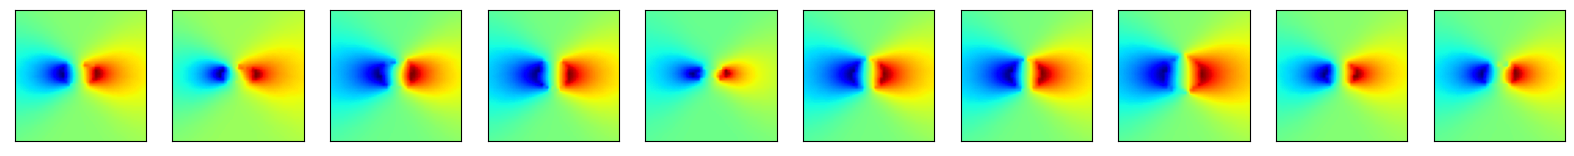

In [55]:
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(image_mechanics[i,:,:,0],cmap='jet')
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [56]:
x_train_mechanics = image_mechanics[:N_split]
x_test_mechanics = image_mechanics[N_split:]
del image_mechanics

**Scaling**

In [57]:
x_mean_mechanics = x_train_mechanics.mean(axis=0)
#x_train_mechanics = x_train_mechanics-x_mean_mechanics
#x_test_mechanics = x_test_mechanics-x_mean_mechanics
x_max_mechanics= abs(x_train_mechanics).max()
x_train_mechanics = x_train_mechanics/x_max_mechanics
x_test_mechanics = x_test_mechanics/x_max_mechanics

In [58]:
x_train_mechanics.shape

(3200, 48, 48, 1)

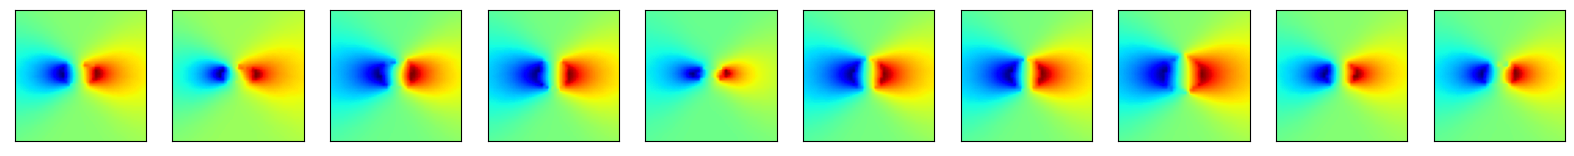

In [59]:
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_train_mechanics[i,:,:,0],cmap='jet')
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [60]:
shape = x_train_mechanics.shape[1:4]
ae_mechanics = AutoEncoder_mechanics(shape, filters=32, latent_dim=LATENT_DIM, lr=2.5e-6, verbose=False)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 48, 48, 1)]       0         
                                                                 
 model_6 (Functional)        (None, 50)                931218    
                                                                 
 model_7 (Functional)        (None, 48, 48, 1)         958817    
                                                                 
Total params: 1,890,035
Trainable params: 1,890,035
Non-trainable params: 0
_________________________________________________________________


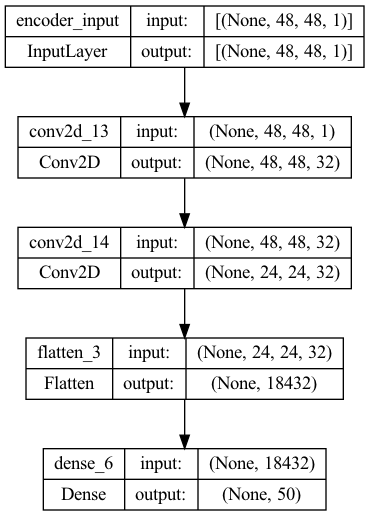

In [61]:
from keras.utils.vis_utils import plot_model
plot_model(ae_mechanics.encoder, show_shapes=True, show_layer_names=True)

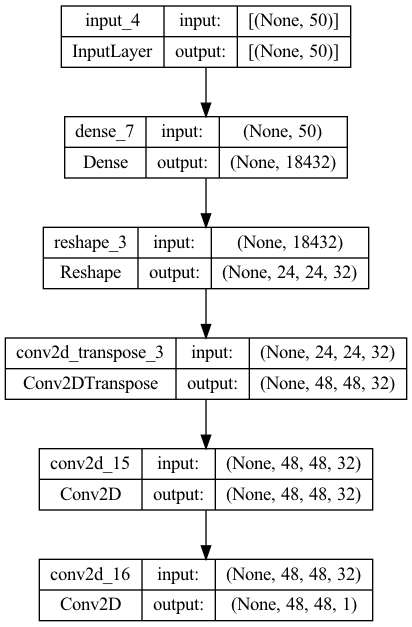

In [62]:
plot_model(ae_mechanics.decoder, show_shapes=True, show_layer_names=True)

In [64]:
epochs = 2000 # 120 #50 150
batch_size = 64 #64 128
history_mechanics = ae_mechanics.fit(x_train_mechanics, epochs, batch_size, validation_split=0.2,callbacks=[tf.keras.callbacks.EarlyStopping(patience=20,)])

Epoch 1/2000
 1/40 [..............................] - ETA: 11s - loss: 8.3934e-04

2022-10-06 11:12:12.876632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 2s 42ms/step - loss: 8.9729e-04 - val_loss: 7.5206e-04
Epoch 2/2000
 1/40 [..............................] - ETA: 1s - loss: 6.7873e-04

2022-10-06 11:12:14.503517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 36ms/step - loss: 8.9215e-04 - val_loss: 7.4679e-04
Epoch 3/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.8653e-04 - val_loss: 7.4083e-04
Epoch 4/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.8015e-04 - val_loss: 7.3402e-04
Epoch 5/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.7280e-04 - val_loss: 7.2613e-04
Epoch 6/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.6421e-04 - val_loss: 7.1688e-04
Epoch 7/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.5412e-04 - val_loss: 7.0590e-04
Epoch 8/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.4206e-04 - val_loss: 6.9274e-04
Epoch 9/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.2750e-04 - val_loss: 6.7670e-04
Epoch 10/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.0950e-04 - val_loss: 6.5680e-04
Epoch 11/2000
40/40 [==========

40/40 [==============================] - 1s 36ms/step - loss: 9.4349e-05 - val_loss: 2.8050e-05
Epoch 77/2000
40/40 [==============================] - 1s 35ms/step - loss: 9.2430e-05 - val_loss: 2.7533e-05
Epoch 78/2000
40/40 [==============================] - 1s 35ms/step - loss: 9.0334e-05 - val_loss: 2.6973e-05
Epoch 79/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.8285e-05 - val_loss: 2.5983e-05
Epoch 80/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.6058e-05 - val_loss: 2.5687e-05
Epoch 81/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.4117e-05 - val_loss: 2.5168e-05
Epoch 82/2000
40/40 [==============================] - 1s 36ms/step - loss: 8.1656e-05 - val_loss: 2.4499e-05
Epoch 83/2000
40/40 [==============================] - 1s 36ms/step - loss: 7.9326e-05 - val_loss: 2.3802e-05
Epoch 84/2000
40/40 [==============================] - 1s 35ms/step - loss: 7.7030e-05 - val_loss: 2.2881e-05
Epoch 85/2000
40/40 [===

40/40 [==============================] - 1s 37ms/step - loss: 1.0363e-05 - val_loss: 7.3991e-06
Epoch 151/2000
40/40 [==============================] - 1s 36ms/step - loss: 1.0273e-05 - val_loss: 7.3868e-06
Epoch 152/2000
40/40 [==============================] - 1s 36ms/step - loss: 1.0188e-05 - val_loss: 7.3749e-06
Epoch 153/2000
40/40 [==============================] - 1s 36ms/step - loss: 1.0104e-05 - val_loss: 7.3621e-06
Epoch 154/2000
40/40 [==============================] - 1s 36ms/step - loss: 1.0033e-05 - val_loss: 7.3510e-06
Epoch 155/2000
40/40 [==============================] - 1s 36ms/step - loss: 9.9508e-06 - val_loss: 7.3384e-06
Epoch 156/2000
40/40 [==============================] - 1s 36ms/step - loss: 9.8756e-06 - val_loss: 7.3279e-06
Epoch 157/2000
40/40 [==============================] - 1s 36ms/step - loss: 9.8063e-06 - val_loss: 7.3159e-06
Epoch 158/2000
40/40 [==============================] - 1s 35ms/step - loss: 9.7403e-06 - val_loss: 7.3045e-06
Epoch 159/2000
4

Epoch 224/2000
40/40 [==============================] - 1s 36ms/step - loss: 7.6386e-06 - val_loss: 6.9252e-06
Epoch 225/2000
40/40 [==============================] - 1s 36ms/step - loss: 7.6233e-06 - val_loss: 6.9231e-06
Epoch 226/2000
40/40 [==============================] - 1s 37ms/step - loss: 7.6084e-06 - val_loss: 6.9248e-06
Epoch 227/2000
40/40 [==============================] - 1s 37ms/step - loss: 7.5940e-06 - val_loss: 6.9181e-06
Epoch 228/2000
40/40 [==============================] - 1s 37ms/step - loss: 7.5796e-06 - val_loss: 6.9163e-06
Epoch 229/2000
40/40 [==============================] - 1s 36ms/step - loss: 7.5649e-06 - val_loss: 6.9143e-06
Epoch 230/2000
40/40 [==============================] - 1s 36ms/step - loss: 7.5519e-06 - val_loss: 6.9106e-06
Epoch 231/2000
40/40 [==============================] - 1s 36ms/step - loss: 7.5387e-06 - val_loss: 6.9058e-06
Epoch 232/2000
40/40 [==============================] - 1s 36ms/step - loss: 7.5250e-06 - val_loss: 6.9043e-06
E

Epoch 298/2000
40/40 [==============================] - 1s 35ms/step - loss: 6.9971e-06 - val_loss: 6.7751e-06
Epoch 299/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.9927e-06 - val_loss: 6.7758e-06
Epoch 300/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.9884e-06 - val_loss: 6.7723e-06
Epoch 301/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.9839e-06 - val_loss: 6.7731e-06
Epoch 302/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.9794e-06 - val_loss: 6.7675e-06
Epoch 303/2000
40/40 [==============================] - 1s 35ms/step - loss: 6.9750e-06 - val_loss: 6.7687e-06
Epoch 304/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.9711e-06 - val_loss: 6.7649e-06
Epoch 305/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.9662e-06 - val_loss: 6.7646e-06
Epoch 306/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.9636e-06 - val_loss: 6.7621e-06
E

Epoch 372/2000
40/40 [==============================] - 1s 37ms/step - loss: 6.7722e-06 - val_loss: 6.6505e-06
Epoch 373/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.7709e-06 - val_loss: 6.6482e-06
Epoch 374/2000
40/40 [==============================] - 1s 37ms/step - loss: 6.7688e-06 - val_loss: 6.6493e-06
Epoch 375/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.7700e-06 - val_loss: 6.6459e-06
Epoch 376/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.7640e-06 - val_loss: 6.6437e-06
Epoch 377/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.7612e-06 - val_loss: 6.6396e-06
Epoch 378/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.7595e-06 - val_loss: 6.6412e-06
Epoch 379/2000
40/40 [==============================] - 1s 35ms/step - loss: 6.7576e-06 - val_loss: 6.6398e-06
Epoch 380/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.7550e-06 - val_loss: 6.6352e-06
E

Epoch 446/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.5913e-06 - val_loss: 6.4844e-06
Epoch 447/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.5887e-06 - val_loss: 6.4800e-06
Epoch 448/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.5837e-06 - val_loss: 6.4768e-06
Epoch 449/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.5816e-06 - val_loss: 6.4720e-06
Epoch 450/2000
40/40 [==============================] - 1s 35ms/step - loss: 6.5784e-06 - val_loss: 6.4727e-06
Epoch 451/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.5743e-06 - val_loss: 6.4686e-06
Epoch 452/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.5718e-06 - val_loss: 6.4622e-06
Epoch 453/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.5677e-06 - val_loss: 6.4621e-06
Epoch 454/2000
40/40 [==============================] - 1s 35ms/step - loss: 6.5638e-06 - val_loss: 6.4577e-06
E

Epoch 520/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.3164e-06 - val_loss: 6.2105e-06
Epoch 521/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.3125e-06 - val_loss: 6.2072e-06
Epoch 522/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.3066e-06 - val_loss: 6.1997e-06
Epoch 523/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.3012e-06 - val_loss: 6.1963e-06
Epoch 524/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.2957e-06 - val_loss: 6.1915e-06
Epoch 525/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.2920e-06 - val_loss: 6.1887e-06
Epoch 526/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.2861e-06 - val_loss: 6.1823e-06
Epoch 527/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.2824e-06 - val_loss: 6.1810e-06
Epoch 528/2000
40/40 [==============================] - 1s 36ms/step - loss: 6.2779e-06 - val_loss: 6.1737e-06
E

Epoch 594/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.8889e-06 - val_loss: 5.7856e-06
Epoch 595/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.8826e-06 - val_loss: 5.7713e-06
Epoch 596/2000
40/40 [==============================] - 1s 37ms/step - loss: 5.8757e-06 - val_loss: 5.7667e-06
Epoch 597/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.8659e-06 - val_loss: 5.7572e-06
Epoch 598/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.8594e-06 - val_loss: 5.7525e-06
Epoch 599/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.8490e-06 - val_loss: 5.7444e-06
Epoch 600/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.8408e-06 - val_loss: 5.7375e-06
Epoch 601/2000
40/40 [==============================] - 1s 35ms/step - loss: 5.8327e-06 - val_loss: 5.7322e-06
Epoch 602/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.8265e-06 - val_loss: 5.7239e-06
E

Epoch 668/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.2616e-06 - val_loss: 5.1733e-06
Epoch 669/2000
40/40 [==============================] - 1s 37ms/step - loss: 5.2523e-06 - val_loss: 5.1585e-06
Epoch 670/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.2444e-06 - val_loss: 5.1503e-06
Epoch 671/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.2329e-06 - val_loss: 5.1368e-06
Epoch 672/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.2262e-06 - val_loss: 5.1297e-06
Epoch 673/2000
40/40 [==============================] - 1s 35ms/step - loss: 5.2148e-06 - val_loss: 5.1171e-06
Epoch 674/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.2070e-06 - val_loss: 5.1101e-06
Epoch 675/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.1966e-06 - val_loss: 5.0983e-06
Epoch 676/2000
40/40 [==============================] - 1s 36ms/step - loss: 5.1855e-06 - val_loss: 5.0921e-06
E

Epoch 742/2000
40/40 [==============================] - 1s 36ms/step - loss: 4.5699e-06 - val_loss: 4.4933e-06
Epoch 743/2000
40/40 [==============================] - 1s 37ms/step - loss: 4.5649e-06 - val_loss: 4.4874e-06
Epoch 744/2000
40/40 [==============================] - 1s 36ms/step - loss: 4.5515e-06 - val_loss: 4.4778e-06
Epoch 745/2000
40/40 [==============================] - 1s 36ms/step - loss: 4.5461e-06 - val_loss: 4.4725e-06
Epoch 746/2000
40/40 [==============================] - 1s 36ms/step - loss: 4.5329e-06 - val_loss: 4.4652e-06
Epoch 747/2000
40/40 [==============================] - 1s 36ms/step - loss: 4.5259e-06 - val_loss: 4.4537e-06
Epoch 748/2000
40/40 [==============================] - 1s 36ms/step - loss: 4.5139e-06 - val_loss: 4.4433e-06
Epoch 749/2000
40/40 [==============================] - 1s 36ms/step - loss: 4.5085e-06 - val_loss: 4.4370e-06
Epoch 750/2000
40/40 [==============================] - 1s 36ms/step - loss: 4.4994e-06 - val_loss: 4.4289e-06
E

Epoch 816/2000
40/40 [==============================] - 1s 37ms/step - loss: 4.0078e-06 - val_loss: 3.9645e-06
Epoch 817/2000
40/40 [==============================] - 1s 36ms/step - loss: 4.0002e-06 - val_loss: 3.9578e-06
Epoch 818/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.9969e-06 - val_loss: 3.9536e-06
Epoch 819/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.9884e-06 - val_loss: 3.9459e-06
Epoch 820/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.9846e-06 - val_loss: 3.9437e-06
Epoch 821/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.9744e-06 - val_loss: 3.9358e-06
Epoch 822/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.9708e-06 - val_loss: 3.9337e-06
Epoch 823/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.9682e-06 - val_loss: 3.9257e-06
Epoch 824/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.9612e-06 - val_loss: 3.9202e-06
E

Epoch 890/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.6047e-06 - val_loss: 3.5914e-06
Epoch 891/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.6009e-06 - val_loss: 3.5882e-06
Epoch 892/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.5956e-06 - val_loss: 3.5826e-06
Epoch 893/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.5933e-06 - val_loss: 3.5776e-06
Epoch 894/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.5881e-06 - val_loss: 3.5755e-06
Epoch 895/2000
40/40 [==============================] - 1s 35ms/step - loss: 3.5877e-06 - val_loss: 3.5720e-06
Epoch 896/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.5840e-06 - val_loss: 3.5671e-06
Epoch 897/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.5730e-06 - val_loss: 3.5582e-06
Epoch 898/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.5922e-06 - val_loss: 3.5696e-06
E

Epoch 964/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.3120e-06 - val_loss: 3.3167e-06
Epoch 965/2000
40/40 [==============================] - 1s 35ms/step - loss: 3.3096e-06 - val_loss: 3.3119e-06
Epoch 966/2000
40/40 [==============================] - 1s 37ms/step - loss: 3.3050e-06 - val_loss: 3.3089e-06
Epoch 967/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.3018e-06 - val_loss: 3.3043e-06
Epoch 968/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.2994e-06 - val_loss: 3.3034e-06
Epoch 969/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.2952e-06 - val_loss: 3.3008e-06
Epoch 970/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.2921e-06 - val_loss: 3.2991e-06
Epoch 971/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.2889e-06 - val_loss: 3.2918e-06
Epoch 972/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.2846e-06 - val_loss: 3.2891e-06
E

40/40 [==============================] - 1s 36ms/step - loss: 3.1057e-06 - val_loss: 3.1076e-06
Epoch 1038/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.0993e-06 - val_loss: 3.1070e-06
Epoch 1039/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.0947e-06 - val_loss: 3.1020e-06
Epoch 1040/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.0851e-06 - val_loss: 3.0986e-06
Epoch 1041/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.0813e-06 - val_loss: 3.0954e-06
Epoch 1042/2000
40/40 [==============================] - 1s 35ms/step - loss: 3.0784e-06 - val_loss: 3.0923e-06
Epoch 1043/2000
40/40 [==============================] - 1s 35ms/step - loss: 3.0743e-06 - val_loss: 3.0914e-06
Epoch 1044/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.0720e-06 - val_loss: 3.0891e-06
Epoch 1045/2000
40/40 [==============================] - 1s 36ms/step - loss: 3.0691e-06 - val_loss: 3.0859e-06
Epoch 10

40/40 [==============================] - 1s 36ms/step - loss: 2.9207e-06 - val_loss: 2.9458e-06
Epoch 1111/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.9191e-06 - val_loss: 2.9438e-06
Epoch 1112/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.9172e-06 - val_loss: 2.9435e-06
Epoch 1113/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.9125e-06 - val_loss: 2.9389e-06
Epoch 1114/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.9101e-06 - val_loss: 2.9375e-06
Epoch 1115/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.9083e-06 - val_loss: 2.9344e-06
Epoch 1116/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.9067e-06 - val_loss: 2.9339e-06
Epoch 1117/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.9044e-06 - val_loss: 2.9313e-06
Epoch 1118/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.9035e-06 - val_loss: 2.9298e-06
Epoch 11

40/40 [==============================] - 1s 36ms/step - loss: 2.8335e-06 - val_loss: 2.8308e-06
Epoch 1184/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.8224e-06 - val_loss: 2.8294e-06
Epoch 1185/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.8337e-06 - val_loss: 2.8339e-06
Epoch 1186/2000
40/40 [==============================] - 1s 37ms/step - loss: 2.8446e-06 - val_loss: 2.8308e-06
Epoch 1187/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.8417e-06 - val_loss: 2.8283e-06
Epoch 1188/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.8321e-06 - val_loss: 2.8282e-06
Epoch 1189/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.8239e-06 - val_loss: 2.8435e-06
Epoch 1190/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.8176e-06 - val_loss: 2.8239e-06
Epoch 1191/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.7994e-06 - val_loss: 2.8192e-06
Epoch 11

40/40 [==============================] - 1s 36ms/step - loss: 2.7040e-06 - val_loss: 2.7440e-06
Epoch 1257/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.7030e-06 - val_loss: 2.7439e-06
Epoch 1258/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.7019e-06 - val_loss: 2.7420e-06
Epoch 1259/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.7009e-06 - val_loss: 2.7414e-06
Epoch 1260/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6999e-06 - val_loss: 2.7427e-06
Epoch 1261/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6989e-06 - val_loss: 2.7398e-06
Epoch 1262/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6978e-06 - val_loss: 2.7395e-06
Epoch 1263/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6968e-06 - val_loss: 2.7373e-06
Epoch 1264/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6957e-06 - val_loss: 2.7360e-06
Epoch 12

40/40 [==============================] - 1s 37ms/step - loss: 2.6422e-06 - val_loss: 2.6837e-06
Epoch 1330/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6413e-06 - val_loss: 2.6837e-06
Epoch 1331/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6404e-06 - val_loss: 2.6835e-06
Epoch 1332/2000
40/40 [==============================] - 1s 37ms/step - loss: 2.6400e-06 - val_loss: 2.6820e-06
Epoch 1333/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6399e-06 - val_loss: 2.6820e-06
Epoch 1334/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6392e-06 - val_loss: 2.6840e-06
Epoch 1335/2000
40/40 [==============================] - 1s 37ms/step - loss: 2.6400e-06 - val_loss: 2.6808e-06
Epoch 1336/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6382e-06 - val_loss: 2.6820e-06
Epoch 1337/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6360e-06 - val_loss: 2.6792e-06
Epoch 13

40/40 [==============================] - 1s 36ms/step - loss: 2.5956e-06 - val_loss: 2.6395e-06
Epoch 1403/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5953e-06 - val_loss: 2.6378e-06
Epoch 1404/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5957e-06 - val_loss: 2.6378e-06
Epoch 1405/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.5962e-06 - val_loss: 2.6401e-06
Epoch 1406/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5999e-06 - val_loss: 2.6388e-06
Epoch 1407/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6016e-06 - val_loss: 2.6372e-06
Epoch 1408/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6061e-06 - val_loss: 2.6352e-06
Epoch 1409/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6131e-06 - val_loss: 2.6373e-06
Epoch 1410/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6249e-06 - val_loss: 2.6433e-06
Epoch 14

40/40 [==============================] - 1s 36ms/step - loss: 2.5575e-06 - val_loss: 2.6033e-06
Epoch 1476/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5575e-06 - val_loss: 2.6042e-06
Epoch 1477/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5571e-06 - val_loss: 2.6043e-06
Epoch 1478/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5561e-06 - val_loss: 2.6018e-06
Epoch 1479/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5553e-06 - val_loss: 2.6020e-06
Epoch 1480/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.5549e-06 - val_loss: 2.6011e-06
Epoch 1481/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5545e-06 - val_loss: 2.6019e-06
Epoch 1482/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5541e-06 - val_loss: 2.6005e-06
Epoch 1483/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5541e-06 - val_loss: 2.6003e-06
Epoch 14

40/40 [==============================] - 1s 36ms/step - loss: 2.5444e-06 - val_loss: 2.5738e-06
Epoch 1549/2000
40/40 [==============================] - 1s 37ms/step - loss: 2.5658e-06 - val_loss: 2.5786e-06
Epoch 1550/2000
40/40 [==============================] - 1s 37ms/step - loss: 2.5994e-06 - val_loss: 2.5995e-06
Epoch 1551/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.6393e-06 - val_loss: 2.6073e-06
Epoch 1552/2000
40/40 [==============================] - 1s 37ms/step - loss: 2.6477e-06 - val_loss: 2.5885e-06
Epoch 1553/2000
40/40 [==============================] - 1s 37ms/step - loss: 2.6076e-06 - val_loss: 2.5745e-06
Epoch 1554/2000
40/40 [==============================] - 1s 37ms/step - loss: 2.5827e-06 - val_loss: 2.5820e-06
Epoch 1555/2000
40/40 [==============================] - 1s 37ms/step - loss: 2.5296e-06 - val_loss: 2.5703e-06
Epoch 1556/2000
40/40 [==============================] - 1s 37ms/step - loss: 2.5306e-06 - val_loss: 2.5702e-06
Epoch 15

40/40 [==============================] - 1s 36ms/step - loss: 2.4991e-06 - val_loss: 2.5449e-06
Epoch 1622/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4984e-06 - val_loss: 2.5449e-06
Epoch 1623/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4985e-06 - val_loss: 2.5451e-06
Epoch 1624/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4971e-06 - val_loss: 2.5443e-06
Epoch 1625/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4976e-06 - val_loss: 2.5445e-06
Epoch 1626/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4976e-06 - val_loss: 2.5426e-06
Epoch 1627/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.4965e-06 - val_loss: 2.5432e-06
Epoch 1628/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4962e-06 - val_loss: 2.5431e-06
Epoch 1629/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4961e-06 - val_loss: 2.5425e-06
Epoch 16

40/40 [==============================] - 1s 36ms/step - loss: 2.4883e-06 - val_loss: 2.5229e-06
Epoch 1695/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5099e-06 - val_loss: 2.5202e-06
Epoch 1696/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5379e-06 - val_loss: 2.5190e-06
Epoch 1697/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5702e-06 - val_loss: 2.5337e-06
Epoch 1698/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.5932e-06 - val_loss: 2.5231e-06
Epoch 1699/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.5879e-06 - val_loss: 2.5686e-06
Epoch 1700/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.5596e-06 - val_loss: 2.5432e-06
Epoch 1701/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.4969e-06 - val_loss: 2.5170e-06
Epoch 1702/2000
40/40 [==============================] - 1s 37ms/step - loss: 2.4705e-06 - val_loss: 2.5155e-06
Epoch 17

40/40 [==============================] - 1s 36ms/step - loss: 2.4543e-06 - val_loss: 2.4924e-06
Epoch 1768/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4555e-06 - val_loss: 2.4929e-06
Epoch 1769/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.4582e-06 - val_loss: 2.4949e-06
Epoch 1770/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4629e-06 - val_loss: 2.4914e-06
Epoch 1771/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4647e-06 - val_loss: 2.4912e-06
Epoch 1772/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.4634e-06 - val_loss: 2.4904e-06
Epoch 1773/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4665e-06 - val_loss: 2.4889e-06
Epoch 1774/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4713e-06 - val_loss: 2.4898e-06
Epoch 1775/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4749e-06 - val_loss: 2.4954e-06
Epoch 17

40/40 [==============================] - 1s 36ms/step - loss: 2.4216e-06 - val_loss: 2.4663e-06
Epoch 1841/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4215e-06 - val_loss: 2.4663e-06
Epoch 1842/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4217e-06 - val_loss: 2.4652e-06
Epoch 1843/2000
40/40 [==============================] - 1s 35ms/step - loss: 2.4209e-06 - val_loss: 2.4653e-06
Epoch 1844/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4197e-06 - val_loss: 2.4636e-06
Epoch 1845/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4201e-06 - val_loss: 2.4647e-06
Epoch 1846/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4198e-06 - val_loss: 2.4630e-06
Epoch 1847/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4202e-06 - val_loss: 2.4630e-06
Epoch 1848/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.4213e-06 - val_loss: 2.4624e-06
Epoch 18

40/40 [==============================] - 1s 36ms/step - loss: 2.3952e-06 - val_loss: 2.4386e-06
Epoch 1914/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3945e-06 - val_loss: 2.4379e-06
Epoch 1915/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3947e-06 - val_loss: 2.4377e-06
Epoch 1916/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3946e-06 - val_loss: 2.4364e-06
Epoch 1917/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3934e-06 - val_loss: 2.4359e-06
Epoch 1918/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3935e-06 - val_loss: 2.4360e-06
Epoch 1919/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3927e-06 - val_loss: 2.4358e-06
Epoch 1920/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3928e-06 - val_loss: 2.4361e-06
Epoch 1921/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3933e-06 - val_loss: 2.4346e-06
Epoch 19

40/40 [==============================] - 1s 36ms/step - loss: 2.3660e-06 - val_loss: 2.4091e-06
Epoch 1987/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3659e-06 - val_loss: 2.4078e-06
Epoch 1988/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3658e-06 - val_loss: 2.4086e-06
Epoch 1989/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3652e-06 - val_loss: 2.4079e-06
Epoch 1990/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3652e-06 - val_loss: 2.4056e-06
Epoch 1991/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3646e-06 - val_loss: 2.4070e-06
Epoch 1992/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3639e-06 - val_loss: 2.4065e-06
Epoch 1993/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3637e-06 - val_loss: 2.4059e-06
Epoch 1994/2000
40/40 [==============================] - 1s 36ms/step - loss: 2.3636e-06 - val_loss: 2.4056e-06
Epoch 19

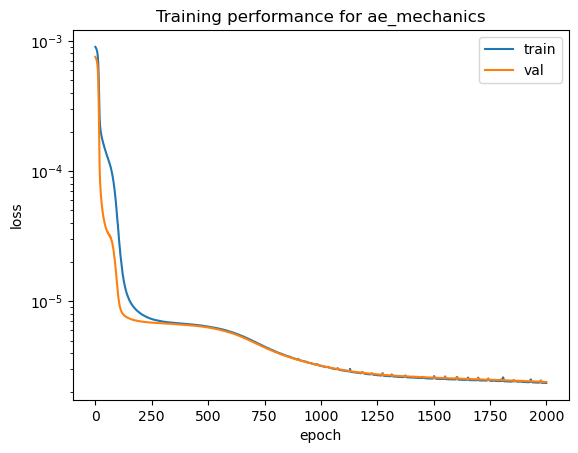

In [65]:
plt.semilogy(history_mechanics.epoch, history_mechanics.history['loss'], label='train')
plt.semilogy(history_mechanics.epoch, history_mechanics.history['val_loss'], label='val')
plt.title('Training performance for ae_mechanics')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [66]:
ae_mechanics.save('ae_mechanics_model')

INFO:tensorflow:Assets written to: ae_mechanics_model/my_autoencoder/assets


INFO:tensorflow:Assets written to: ae_mechanics_model/my_autoencoder/assets


INFO:tensorflow:Assets written to: ae_mechanics_model/my_encoder/assets


INFO:tensorflow:Assets written to: ae_mechanics_model/my_encoder/assets


INFO:tensorflow:Assets written to: ae_mechanics_model/my_decoder/assets


INFO:tensorflow:Assets written to: ae_mechanics_model/my_decoder/assets


Multimodal AE for defect and displacement 0 only

In [67]:
image_dof0 = np.load('All_dof_fluctuations.npy').reshape(4000,48,48,6)
image_dof0 = image_dof0[:,:,:,0]
image_dof0 = np.expand_dims(image_dof0, axis = 3)
image_dof0_train = image_dof0[:N_split]
image_dof0_test = image_dof0[N_split:]
del image_dof0
image_dof0_train = (image_dof0_train - x_mean_mechanics)/x_max_mechanics
image_dof0_test = (image_dof0_test - x_mean_mechanics)/x_max_mechanics
Z_latent_mechanics_train = ae_mechanics.encoder(image_dof0_train)
Z_latent_mechanics_test = ae_mechanics.encoder(image_dof0_test)

In [68]:
Z_latent_mechanics_train.shape

TensorShape([3200, 50])

MMAE for latent variables

(Z_defect,Z_mechanics) -> Z -> (Z_defect,Z_mechanics)

In [70]:
class MultiAutoEncoder:
    
    def __init__(self, shapes, latent_dim=2, lr=0.004, verbose=True, loss="mse",alpha=0.5):
        """
        Autoencoder for multimodal latent variables.

        Arguments:
            shapes: shapes of the input image [size_x, size_y, 1], [size_x, size_y, 2]
            latent_dim = size of the latent space (dimensions of the reduced space)
            lr: learning rate
            verbose = Boolean, if True, will print information about the models

        1 - latent variable for defect images 
        2 - letent variable for mechanical variable
        """
        
        self.input_shape1 = shapes[0]
        self.input_shape2 = shapes[0]
        self.latent_dim = latent_dim
        self.verbose = verbose

        # First build the Encoder Model
        inputs1 = Input(shape=self.input_shape1, name='encoder_input')
        inputs2 = Input(shape=self.input_shape2, name='encoder_input')
        x1 = inputs1
        x2 = inputs2

        last_shape1 = K.int_shape(x1)
        last_shape2 = K.int_shape(x2)
        if verbose :
            print(f"last_shape1 = {last_shape1}, last_shape2 = {last_shape2}")

        # Generate the latent vector
        latent1 = Dense(self.latent_dim)(Dense(self.latent_dim)(x1))
        latent2 = Dense(self.latent_dim)(Dense(self.latent_dim)(x2))

        # Instantiate Encoders Model
        self.encoder1 = Model(inputs1, latent1, name="encoder1")
        self.encoder2 = Model(inputs2, latent2, name="encoder2")
        
        if self.verbose:
            self.encoder1.summary()
            self.encoder2.summary()

        #Instantiate global encoder model
        inputs_global = Input(shape=(last_shape1[1],2))
        input1 = inputs_global[:,:,0]
        input2 = inputs_global[:,:,1]
        latent1 = self.encoder1(input1)
        latent2 = self.encoder2(input2)
        latent = (latent1 + latent2)/2
        self.encoder = Model(inputs_global,latent,name="encoder")
        if self.verbose:
            self.encoder.summary()

        # Build the Decoder Model
        latent_inputs = Input(shape=(latent_dim,))
        outputs1 = Dense(last_shape1[1] )(latent_inputs)
        outputs2 = Dense(last_shape2[1] )(latent_inputs)
        
        # Instantiate Decoder Model
        self.decoder1 = Model(latent_inputs, outputs1, name="decoder1",)
        self.decoder2 = Model(latent_inputs, outputs2, name="decoder2")
        outputs = stack([outputs1,outputs2],axis=2)
        self.decoder = Model(latent_inputs,outputs, name="decoder")
        if self.verbose:
            self.decoder1.summary()
            self.decoder2.summary()
            self.decoder.summary()

        # Autoencoder = Encoder + Decoder
        # Instantiate Autoencoder Model
        self.autoencoder = Model(inputs_global, 
                                self.decoder(self.encoder(inputs_global)),
                                name='autoencoder')
        if self.verbose:
            self.autoencoder.summary()

        #predictor
        self.predictor = Model(inputs1,self.decoder2(self.encoder1(inputs1)),
                               name="predictor")

        self.predictor2 = Model(inputs1,self.decoder1(self.encoder1(inputs1)),
                               name="predictor2")

        if self.verbose:
            self.predictor.summary()
            self.predictor2.summary()

        #personalized loss
        mse = MeanSquaredError()

        def my_loss(x,y) :
            x1 = x[:,:,0]
            x2 = x[:,:,1]

            #latent space
            z1 = self.encoder1(x1)
            z2 = self.encoder2(x2)
            z = self.encoder(x)

            #losses for reconstructions
            y1 = self.decoder1(z)
            y2 = self.decoder2(z)

            #variance in the latent space
            #corr = tfp.stats.correlation(z1,z2,event_axis=None,sample_axis=1)
            var1 = tfp.stats.variance(z1,sample_axis = 0)
            var2 = tfp.stats.variance(z2,sample_axis = 0)

            #losses for predictions
            #y2_pred = self.decoder2(z1)
            #y1_pred = self.decoder1(z2)
            
            return  mse(z1,z2) + (mse(x1,y1) + 10*mse(x2,y2)) + 10*mse(z,x2)


        
        ## Compile it with an appropriate loss function             
        self.autoencoder.compile(optimizer= Nadam(learning_rate=lr), loss=my_loss) 
        self.predictor.compile(optimizer= Nadam(learning_rate=lr), loss=my_loss)
        self.predictor2.compile(optimizer= Nadam(learning_rate=lr), loss=my_loss)


    def fit(self, data, epochs, batch_size, validation_split=0.2,callbacks=None):
        return self.autoencoder.fit(x=data, 
                             y=data, 
                             validation_split=validation_split,
                             shuffle=True, 
                             epochs=epochs, 
                             batch_size=batch_size,
                             callbacks=callbacks)

    def predict(self, batch):
        """Autoencode batch of images"""
        return self.autoencoder.predict(batch)

    def predict_mechanics(self,batch):
        """for a given image, predict deformations"""
        return self.predictor.predict(batch)
    
    def predict_image(self,batch):
        """for given image, predict the image for error estimation"""
        return self.predictor2.predict(batch)

    def predict_latent_representation(self,batch):
        """for a given (image,deformations), predict the latent space representation"""
        input1 = batch[:,0]
        input2 = batch[:,1]
        latent1 = self.encoder1.predict(input1)
        latent2 = self.encoder2.predict(input2)
        latent1 = np.expand_dims(latent1,axis=2)
        latent2 = np.expand_dims(latent2,axis=2)
        return np.concatenate((latent1,latent2), axis =2)
    
    def decode(self,batch):
        """for a given code, decode and print the images/deformations"""
        output1 = self.decoder1(batch)
        output2 = self.decoder2(batch)
        return output1, output2

    def save(self, path):
        self.autoencoder.save(path + '/my_autoencoder')
        self.encoder.save(path + '/my_encoder')
        self.decoder.save(path + '/my_decoder')

    def load_model(self, path):
        self.autoencoder = load_model(path + '/my_autoencoder')
        self.encoder = load_model(path + '/my_encoder')
        self.decoder = load_model(path + '/my_decoder')

In [71]:
Z_train_mmae = stack([Z_latent_defects_train,Z_latent_mechanics_train],axis=2)
Z_test_mmae = stack([Z_latent_defects_test,Z_latent_mechanics_test],axis=2)
shape = Z_train_mmae.shape[1:]
print('shape',shape)
LATENT_DIM_MMAE = LATENT_DIM #np.round(LATENT_DIM / 2).astype(int)
print('LATENT_DIM_MMAE',LATENT_DIM_MMAE)
mmae = MultiAutoEncoder(shape, latent_dim=LATENT_DIM_MMAE, lr=5.e-5, verbose=False)

NameError: name 'Z_latent_defects_train' is not defined

In [247]:
epochs = 500 # 120 #50 150
batch_size = 64
history_mmae = mmae.fit(Z_train_mmae, epochs, batch_size, validation_split=0.2,callbacks=[tf.keras.callbacks.EarlyStopping(patience=20,)])

Epoch 1/1500


2022-09-28 17:41:40.490004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 2s 23ms/step - loss: 853.6706 - val_loss: 642.2130
Epoch 2/1500


2022-09-28 17:41:42.328276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 15ms/step - loss: 517.8074 - val_loss: 425.7502
Epoch 3/1500
40/40 [==============================] - 1s 14ms/step - loss: 367.9466 - val_loss: 327.1907
Epoch 4/1500
40/40 [==============================] - 1s 13ms/step - loss: 297.1932 - val_loss: 277.3721
Epoch 5/1500
40/40 [==============================] - 1s 13ms/step - loss: 259.9099 - val_loss: 249.3280
Epoch 6/1500
40/40 [==============================] - 1s 13ms/step - loss: 237.6872 - val_loss: 231.2685
Epoch 7/1500
40/40 [==============================] - 1s 13ms/step - loss: 222.7832 - val_loss: 218.4358
Epoch 8/1500
40/40 [==============================] - 1s 13ms/step - loss: 211.8093 - val_loss: 208.7043
Epoch 9/1500
40/40 [==============================] - 1s 14ms/step - loss: 203.2194 - val_loss: 200.8184
Epoch 10/1500
40/40 [==============================] - 1s 14ms/step - loss: 196.1092 - val_loss: 194.1465
Epoch 11/1500
40/40 [==============================] - 1s 13ms/step

40/40 [==============================] - 1s 13ms/step - loss: 20.4691 - val_loss: 20.5900
Epoch 159/1500
40/40 [==============================] - 0s 12ms/step - loss: 20.2945 - val_loss: 20.4164
Epoch 160/1500
40/40 [==============================] - 0s 12ms/step - loss: 20.1250 - val_loss: 20.2451
Epoch 161/1500
40/40 [==============================] - 1s 13ms/step - loss: 19.9588 - val_loss: 20.0781
Epoch 162/1500
40/40 [==============================] - 0s 12ms/step - loss: 19.7905 - val_loss: 19.9114
Epoch 163/1500
40/40 [==============================] - 0s 12ms/step - loss: 19.6274 - val_loss: 19.7458
Epoch 164/1500
40/40 [==============================] - 0s 12ms/step - loss: 19.4668 - val_loss: 19.5827
Epoch 165/1500
40/40 [==============================] - 1s 13ms/step - loss: 19.3050 - val_loss: 19.4244
Epoch 166/1500
40/40 [==============================] - 1s 13ms/step - loss: 19.1451 - val_loss: 19.2638
Epoch 167/1500
40/40 [==============================] - 1s 13ms/step -

40/40 [==============================] - 1s 13ms/step - loss: 6.7888 - val_loss: 6.8363
Epoch 316/1500
40/40 [==============================] - 0s 12ms/step - loss: 6.7526 - val_loss: 6.7904
Epoch 317/1500
40/40 [==============================] - 0s 12ms/step - loss: 6.7159 - val_loss: 6.7952
Epoch 318/1500
40/40 [==============================] - 0s 12ms/step - loss: 6.6804 - val_loss: 6.7126
Epoch 319/1500
40/40 [==============================] - 1s 13ms/step - loss: 6.6361 - val_loss: 6.6740
Epoch 320/1500
40/40 [==============================] - 1s 13ms/step - loss: 6.5934 - val_loss: 6.6347
Epoch 321/1500
40/40 [==============================] - 0s 12ms/step - loss: 6.5646 - val_loss: 6.5942
Epoch 322/1500
40/40 [==============================] - 1s 13ms/step - loss: 6.5210 - val_loss: 6.5619
Epoch 323/1500
40/40 [==============================] - 1s 13ms/step - loss: 6.4831 - val_loss: 6.5208
Epoch 324/1500
40/40 [==============================] - 1s 13ms/step - loss: 6.4496 - va

40/40 [==============================] - 1s 13ms/step - loss: 3.0773 - val_loss: 3.1061
Epoch 474/1500
40/40 [==============================] - 0s 12ms/step - loss: 3.0660 - val_loss: 3.0907
Epoch 475/1500
40/40 [==============================] - 1s 13ms/step - loss: 3.0576 - val_loss: 3.0834
Epoch 476/1500
40/40 [==============================] - 0s 12ms/step - loss: 3.0509 - val_loss: 3.0574
Epoch 477/1500
40/40 [==============================] - 0s 12ms/step - loss: 3.0243 - val_loss: 3.0487
Epoch 478/1500
40/40 [==============================] - 1s 13ms/step - loss: 3.0127 - val_loss: 3.0323
Epoch 479/1500
40/40 [==============================] - 1s 13ms/step - loss: 3.0019 - val_loss: 3.0181
Epoch 480/1500
40/40 [==============================] - 0s 12ms/step - loss: 2.9846 - val_loss: 3.0088
Epoch 481/1500
40/40 [==============================] - 0s 12ms/step - loss: 2.9767 - val_loss: 2.9945
Epoch 482/1500
40/40 [==============================] - 1s 13ms/step - loss: 2.9631 - va

40/40 [==============================] - 0s 12ms/step - loss: 1.7432 - val_loss: 1.7752
Epoch 632/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.7366 - val_loss: 1.7342
Epoch 633/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.7210 - val_loss: 1.7295
Epoch 634/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.7153 - val_loss: 1.7281
Epoch 635/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.7226 - val_loss: 1.7331
Epoch 636/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.7022 - val_loss: 1.7145
Epoch 637/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.6968 - val_loss: 1.7146
Epoch 638/1500
40/40 [==============================] - 1s 13ms/step - loss: 1.6973 - val_loss: 1.7096
Epoch 639/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.7053 - val_loss: 1.7220
Epoch 640/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.6945 - va

40/40 [==============================] - 1s 13ms/step - loss: 1.1642 - val_loss: 1.3075
Epoch 790/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.1692 - val_loss: 1.1610
Epoch 791/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.1480 - val_loss: 1.1737
Epoch 792/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.1481 - val_loss: 1.1521
Epoch 793/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.1548 - val_loss: 1.1690
Epoch 794/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.1428 - val_loss: 1.1552
Epoch 795/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.1356 - val_loss: 1.1470
Epoch 796/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.1527 - val_loss: 1.1447
Epoch 797/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.1357 - val_loss: 1.1752
Epoch 798/1500
40/40 [==============================] - 0s 12ms/step - loss: 1.1349 - va

40/40 [==============================] - 0s 12ms/step - loss: 0.8670 - val_loss: 0.8763
Epoch 948/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.8780 - val_loss: 0.8993
Epoch 949/1500
40/40 [==============================] - 1s 13ms/step - loss: 0.8652 - val_loss: 0.8765
Epoch 950/1500
40/40 [==============================] - 1s 13ms/step - loss: 0.8613 - val_loss: 0.8667
Epoch 951/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.8745 - val_loss: 0.9148
Epoch 952/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.8689 - val_loss: 0.8639
Epoch 953/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.8651 - val_loss: 0.8658
Epoch 954/1500
40/40 [==============================] - 1s 13ms/step - loss: 0.8598 - val_loss: 0.8580
Epoch 955/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.8522 - val_loss: 0.8694
Epoch 956/1500
40/40 [==============================] - 1s 13ms/step - loss: 0.8720 - va

Epoch 1105/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.7031 - val_loss: 0.7050
Epoch 1106/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.7228 - val_loss: 0.7023
Epoch 1107/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6963 - val_loss: 0.7074
Epoch 1108/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.7042 - val_loss: 0.7204
Epoch 1109/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6974 - val_loss: 0.6948
Epoch 1110/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6932 - val_loss: 0.7028
Epoch 1111/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.7003 - val_loss: 0.7222
Epoch 1112/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.7390 - val_loss: 0.6966
Epoch 1113/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6900 - val_loss: 0.6913
Epoch 1114/1500
40/40 [==============================] - 0s 12ms

Epoch 1184/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6593 - val_loss: 0.6444
Epoch 1185/1500
40/40 [==============================] - 1s 13ms/step - loss: 0.6491 - val_loss: 0.6574
Epoch 1186/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6568 - val_loss: 0.6933
Epoch 1187/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6495 - val_loss: 0.6559
Epoch 1188/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6430 - val_loss: 0.6422
Epoch 1189/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6498 - val_loss: 0.6430
Epoch 1190/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6384 - val_loss: 0.6617
Epoch 1191/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6550 - val_loss: 0.6416
Epoch 1192/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6384 - val_loss: 0.6529
Epoch 1193/1500
40/40 [==============================] - 0s 12ms

Epoch 1263/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5929 - val_loss: 0.5963
Epoch 1264/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6134 - val_loss: 0.5943
Epoch 1265/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5927 - val_loss: 0.6125
Epoch 1266/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5979 - val_loss: 0.6377
Epoch 1267/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5952 - val_loss: 0.5958
Epoch 1268/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5893 - val_loss: 0.5920
Epoch 1269/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6283 - val_loss: 0.6084
Epoch 1270/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5884 - val_loss: 0.5916
Epoch 1271/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5971 - val_loss: 0.5970
Epoch 1272/1500
40/40 [==============================] - 0s 12ms

Epoch 1342/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5694 - val_loss: 0.5501
Epoch 1343/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5635 - val_loss: 0.5502
Epoch 1344/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5535 - val_loss: 0.5528
Epoch 1345/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.6005 - val_loss: 0.5548
Epoch 1346/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5479 - val_loss: 0.5479
Epoch 1347/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5496 - val_loss: 0.5558
Epoch 1348/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5493 - val_loss: 0.5526
Epoch 1349/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5494 - val_loss: 0.5571
Epoch 1350/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5984 - val_loss: 0.6183
Epoch 1351/1500
40/40 [==============================] - 0s 12ms

Epoch 1421/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5248 - val_loss: 0.5181
Epoch 1422/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5391 - val_loss: 0.5190
Epoch 1423/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5243 - val_loss: 0.5137
Epoch 1424/1500
40/40 [==============================] - 1s 13ms/step - loss: 0.5205 - val_loss: 0.5331
Epoch 1425/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5229 - val_loss: 0.5925
Epoch 1426/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5383 - val_loss: 0.5134
Epoch 1427/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5156 - val_loss: 0.5284
Epoch 1428/1500
40/40 [==============================] - 1s 13ms/step - loss: 0.5335 - val_loss: 0.5137
Epoch 1429/1500
40/40 [==============================] - 0s 12ms/step - loss: 0.5148 - val_loss: 0.5190
Epoch 1430/1500
40/40 [==============================] - 0s 12ms

Epoch 1500/1500
40/40 [==============================] - 1s 13ms/step - loss: 0.5155 - val_loss: 0.4855


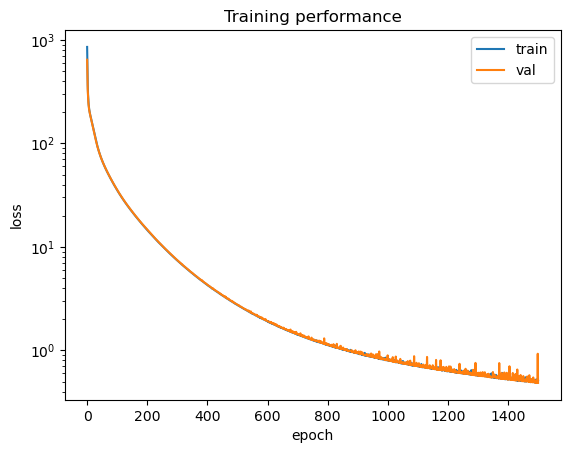

In [248]:
plt.semilogy(history_mmae.epoch, history_mmae.history['loss'], label='train')
plt.semilogy(history_mmae.epoch, history_mmae.history['val_loss'], label='val')
plt.title('Training performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [244]:
y_mechanics = np.array(ae_mechanics.decoder(mmae.predict_mechanics(ae_defects.encoder(x_train))))
y_defect = np.array(ae_defects.decoder(mmae.predict_image(ae_defects.encoder(x_train))))
print(y_mechanics.shape)

  4/100 [>.............................] - ETA: 2s 

2022-09-28 17:40:54.812513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 95/100 [===========================>..] - ETA: 0s

2022-09-28 17:40:57.467880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 0s 2ms/step
(3200, 48, 48, 1)


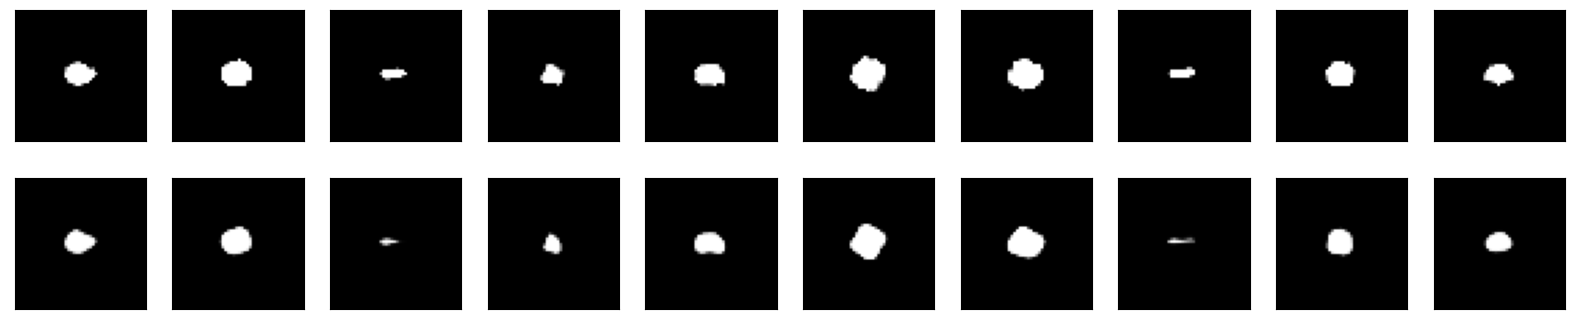

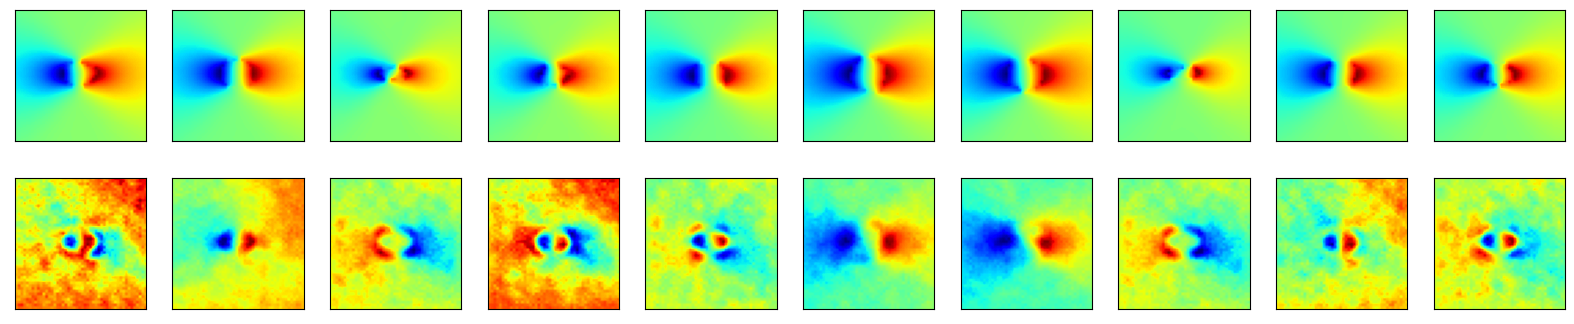

In [245]:
n = 10  # how many digits we will display
shift = 6 * n  # change this value to look at other test images
plt.figure(figsize=(20, 4))
for i in range(n):
    iii = shift+i
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[iii].reshape(48, 48),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_defect[iii].reshape(48, 48),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.figure(figsize=(20, 4))
for i in range(n):
    iii = shift+i
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_mechanics[iii].reshape(48, 48),cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_mechanics[iii].reshape(48, 48),cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
